# PATHOverview interactive notebook

### This notebook contains an interactive figure for setting PATHOverview parametes for each slide detailed in an excel worksheet. Multi-panel figures and a pdf are then generated from this worksheet.

PATHOverview rotates, crops and zooms images to generate customised figures.<br>
PATHOverview requires the packages:<br>
- OpenSlide and openslide-python. 
  - The OpenSlide main package and openslide-python bindings are required
- pillow, openpyxl, matplotlib, pandas, ipywidgets, ipympl

Virtual Slides are accesses using OpenSlide (openslide.org).<br>
Note: For windows users the PATH to openslide\bin must be provided after pathoverview import by setting pathoverview.OPENSLIDE_PATH. OpenSlide is imported using this path when the first slide object is loaded. This is not requred on unix systems.

This example uses freely available ndpi images from OpenSlide: https://openslide.cs.cmu.edu/download/openslide-testdata/Hamamatsu/

Slides are loaded as pathoverview.slide_obj objects with the following parameters available:
- .rot = rotation of the slide in degrees.
- .mirror = True/False to flip the image.
- .zoom_point = tuple of the point on the slide to centre zoom image on. coordinates are given relative to the unrotated uncropped slide size. <br>
ie. (0.5,0.5) is the centre of the slide.
- .crop = tuple containing coordinates of centre of the crop ROI (as .zoom_point), crop width relative to unrotated slide width, crop height relative to unrotated slide height. <br>
ie. ((0.5,0.5), 0.75, 0.75) will give a ROI centred on the slide centre with width and height 0.75x that of the slide

Slide and figure parameters can be loaded from an excel file containing:
- worksheet: slides<br>
  A slide may appear more than once to be on multiple pages or with different parameters
    - root: directory containing the virtual slide file
    - file: virtual slide file
    - order: location on figure page. 0 is first position. missing locations are left empty
    - label: label for this panel on the page
    - page: page number for this image
    - rotation: slide_obj parameter. Default 0
    - mirror: slide_obj parameter. Default False
    - zoom_point: slide_obj parameter. Default (0.5,0.5) ie. centre of slide
    - crop: slide_obj parameter. Default None ie. whole slide is returned
<br>
- worksheet: pages
    - page: page number to map to slides
    - title1: first line of title
    - title2: title second line
    - title3: title third line
    - footer: footer text. May contain {reference to global variable}
    - filename: filename for image export
    
**This notebook can be used to add the roation, mirror, zoom_point and crop parameters to the excel worksheet. The automated generation of multipanel figures from these parameters is performed at the bottom of this notebook.**

**This interactive figure does not currently display the saved parameters for each slide. Once you click save these are written to the slides dataframe but not re-drawn when the interactive slide is accessed again.**

In [1]:
import pathoverview
from pathoverview import pathoverview_interactive_fig, slide_obj, pathofigure

# matplotlib is used to generate the interactive figure
%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
# set interactive (with reference to IPython) to false so figures are only drawn when needed
matplotlib.interactive(False) 

# ipywidget supplies interactive buttons used for moving between slides
from ipywidgets import Layout, widgets

# Pandas handles excel sheet <-> data frame data handling
import pandas as pd

# The python builtin Path is used to handle filepaths nicely between windows and mac
from pathlib import Path

In [2]:
# On windows the path to your OpenSlide binaries must be defined before first slide_obj creation
# This is not requred/used on mac
pathoverview.OPENSLIDE_PATH = r''

In [3]:
slides_excel = Path(r".\test_files\slide_lists.xlsx")
slides_df = pd.read_excel(slides_excel,sheet_name="slides", index_col=0)
slides_df = slides_df.astype('object')

In [4]:
# helper functions for changing between slides
sld = 0
def get_next_image(direction = 1):
    global sld
    sld = (sld + direction) % len(slides_df)
    return get_image_filename(sld)
    
def get_image_filename(num):
    return Path(slides_df['root'][num],slides_df['file'][num])


In [5]:
# functions for navigation buttons
def button_next(_):
    myfig.load_image(get_next_image(1))
    slide_selector.index = sld
    myfig.update_fig()

def button_prev(_):
    myfig.load_image(get_next_image(-1))
    slide_selector.index = sld
    myfig.update_fig()
    
def button_save(_):
    global slides
    data = myfig.get_data()
    for key, val in data.items():
        slides_df.at[sld,key] = val

def button_savenext(_):
    button_save(None)
    button_next(None)

def button_reset(_):
    myfig.reset_fig()

def button_mirror(_):
    myfig.mirror =  not myfig.mirror
    myfig.clear_rect()
    myfig.update_fig()

def dropdown_change(change):
    global sld
    if change['type'] == 'change' and change['name'] == 'index':
        sld = change['new']
        myfig.load_image(get_image_filename(sld))
        myfig.update_fig()

b_layout = Layout(width='15%')
next_button = widgets.Button(description='>', layout=b_layout)
next_button.on_click(button_next)

prev_button = widgets.Button(description='<', layout=b_layout)
prev_button.on_click(button_prev)

save_button = widgets.Button(description='Save', layout=b_layout)
save_button.on_click(button_save)

savenext_button = widgets.Button(description='Save & >', layout=b_layout)
savenext_button.on_click(button_savenext)

reset_button = widgets.Button(description='Reset', layout=b_layout)
reset_button.on_click(button_reset)

mirror_button = widgets.Button(description='Mirror', layout=b_layout)
mirror_button.on_click(button_mirror)

slide_selector = widgets.Dropdown(
    options=slides_df["file"] + " - " + slides_df["label"],
    index=sld,
    description='Slide:',
    disabled=False,
)
slide_selector.observe(dropdown_change)

In [6]:
# Create an interactive figure
myfig = pathoverview_interactive_fig(get_next_image(0))

Right click: rotate this point to top
Double click: set zoom point
Draw box: set crop region
Red dot is slide centre. Green dot is zoom_point


Dropdown(description='Slide:', options=('OS-1.ndpi - Slide1', 'OS-2.ndpi - Slide2', 'OS-1.ndpi - Slide1Sub', '…

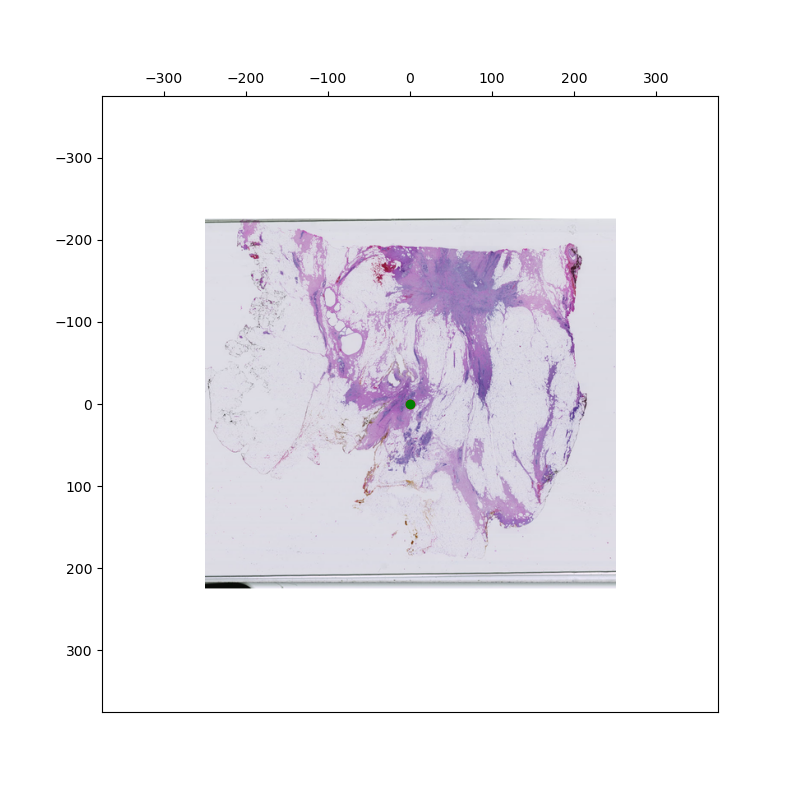

None

In [7]:
# show the interactive figure and navigation buttons
print("Right click: rotate this point to top")
print("Double click: set zoom point")
print("Draw box: set crop region")
print("Red dot is slide centre. Green dot is zoom_point")
display(slide_selector)
display(widgets.HBox([prev_button, mirror_button, save_button, reset_button, next_button, savenext_button]))
display(myfig.fig.show())

In [ ]:
slides_df

In [ ]:
# data for the current figure can be collected with:
myfig.get_data()

In [ ]:
# slide parameters are saved in slide_df. This can be saved to the original excel file.
with pd.ExcelWriter(slides_excel, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
    slides_df.to_excel(writer, sheet_name="slides")  

### Automated slide figure creation 
Slide parameters are taken from slides_df generated above<br>
Parameters for multi-panel pages are taken from slides_df and pages sheet of excel workbook

In [8]:
pages_df = pd.read_excel(slides_excel,sheet_name="pages", index_col=0)

In [9]:
pages_df

page        title1     title2  title3  footer  \
0     0  Page 1 Title        NaN     NaN     NaN   
1     1  Page 2 Title  Sub-views     NaN     NaN   

                                 filename  
0  .\test_files\test_figure_output_1.tiff  
1  .\test_files\test_figure_output_2.tiff

Parameters for figure page layout can be set for the pathofigure class.<br>
Titles and footers are formatted with global variables at time of use.

In [10]:
# # Variables to set page layout
# # Main image
# pathofigure.panel_size = (500,500) #Default (500,500)
pathofigure.scale_bar = 5000 #Default 1000 um
pathofigure.scale_bar_mm = pathofigure.scale_bar / 1000 #for footer, not recalculated on .scale_bar change

# # Inset image
# pathofigure.add_inset = True #Default True
# pathofigure.inset_size = (200,200) #Default (200,200)
# pathofigure.inset_real_size = 250 #Default 250 um
# pathofigure.inset_scale_bar = None #Default None

# pathofigure.figsize = (8.27,11.69) #Default (8.27,11.69) A4 in inches
pathofigure.n_panels_x = 2 #Default 4
pathofigure.n_panels_y = 3 #Default 6

# str.format(**globals()) is applied at time of use.
pathofigure.title_overwrite = None #Default None
pathofigure.footer_overwrite = "Scale bar {pathofigure.scale_bar_mm}mm. Inset image width {pathofigure.inset_real_size}um."

#### Create a figure/page using pathoverview.pathofigure.fig_from_df()
Parameters are taken from pages_df and slides_df. Returned images are stored in pgs list for later use / addition to a multipage pdf.

In [11]:
pgs = []
for index, row in pages_df.iterrows():
    pg = pathofigure.fig_from_df(slides_df[slides_df["page"]==row["page"]], row)
    pgs.append(pg)
    # save this individual figure/page. This uses the matplotlib builtin savefig so 
    # filenames should be wrapped in Path to ensure win/mac compatability
    pg.savefig(Path(row["filename"]))
    print(f"Page {index} done")
print(f"Total pages: {len(pgs)}")

Page 0 done
Page 1 done
Total pages: 2


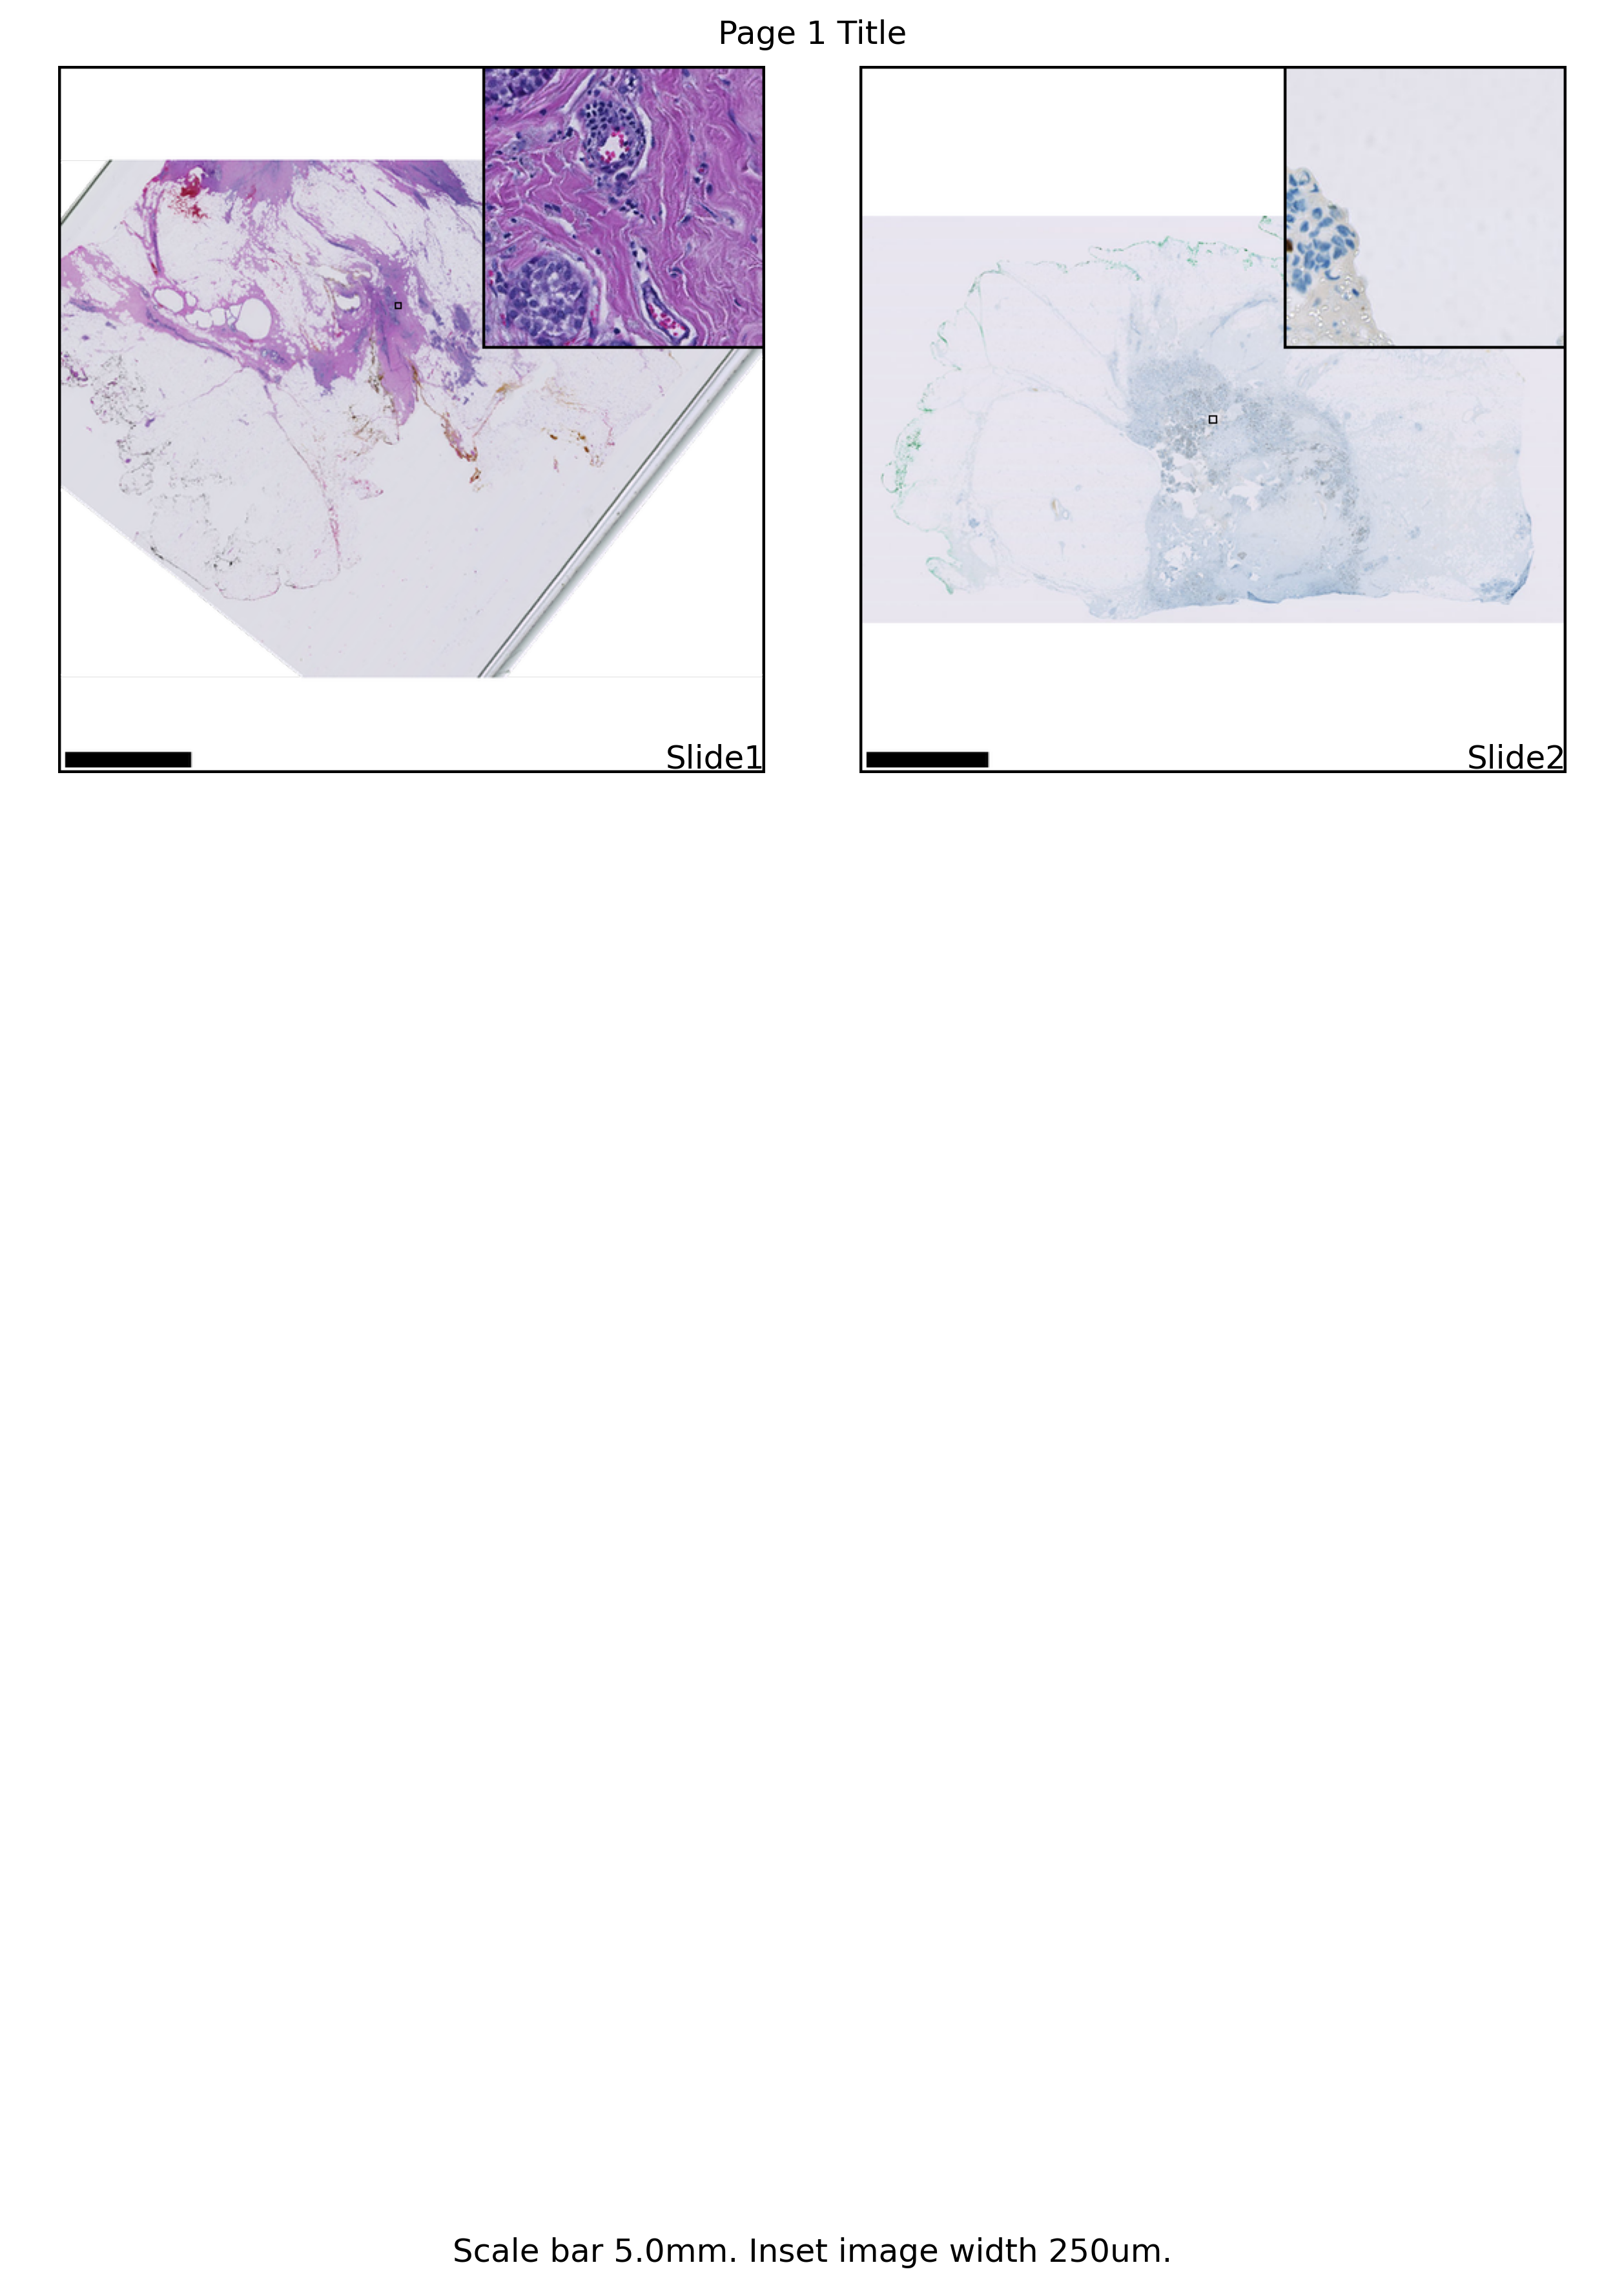

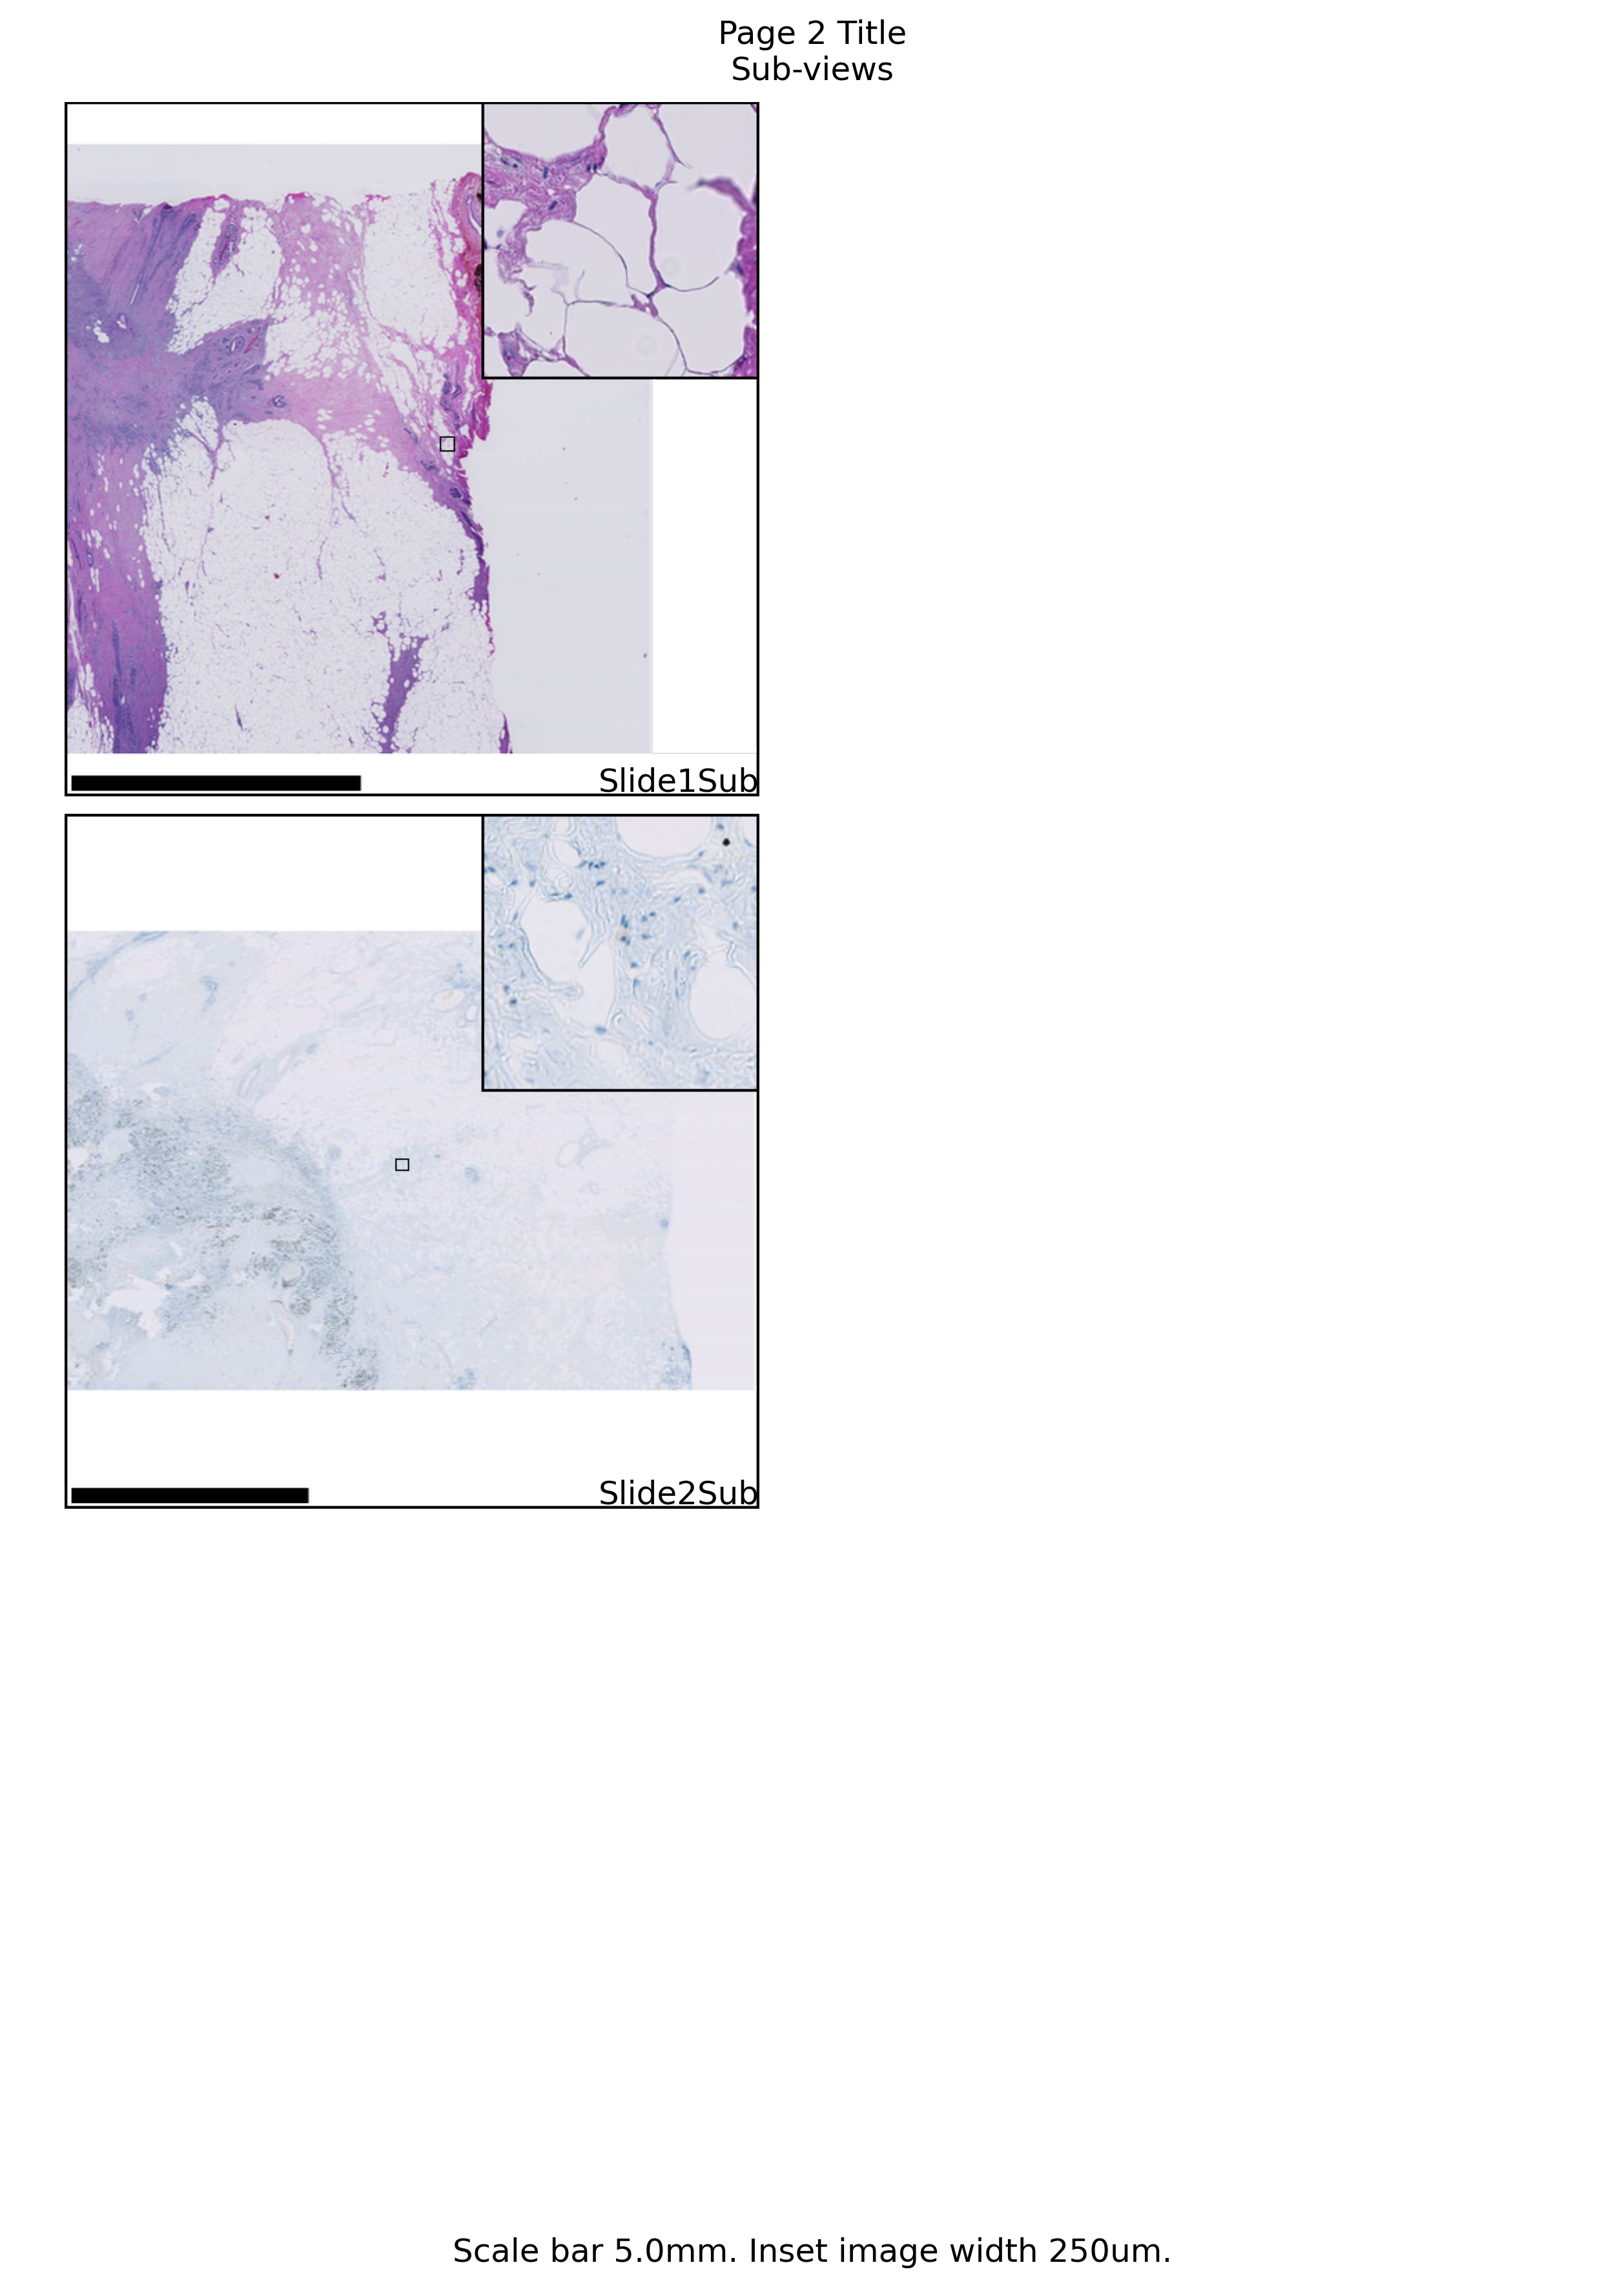

In [12]:
for p in pgs:
    display(p)

#### Create multi-page pdf of figures generated above.
Use pathoverview.pathofigure.save_pdf() to add all figures/pages in pgs to a single pdf

In [13]:
pdf_filename = Path(r".\test_files\test_output.pdf")
pathofigure.save_pdf(pgs, pdf_filename)